## predicting age from image

In [1]:

from fastai.vision.all import *


In [36]:

from fastcore.basics import Int
from fastcore.transform import DisplayedTransform
from fastcore.xtras import Path

from fastai.callback.progress import ProgressCallback
from fastai.callback.schedule import fine_tune

from fastai.data.block import DataBlock, RegressionBlock
from fastai.data.transforms import RandomSplitter, get_image_files, ColReader

from fastai.losses import MSELossFlat

from fastai.torch_core import ShowTitle, show_title, TitledFloat

from fastai.vision.augment import Resize, aug_transforms, Flip, Rotate, Zoom, Warp
from fastai.vision.data import ImageBlock
from fastai.vision.learner import cnn_learner

from torchvision.models.resnet import resnet50

from datetime import datetime, timedelta


import pandas as pd
from scipy.io import loadmat
import numpy as np

from scipy.io import loadmat
from datetime import datetime, timedelta

from fastai.metrics import mae, rmse, R2Score


In [6]:

## Builds wiki_crop DataFrame based on 
## https://sefiks.com/2019/02/13/apparent-age-and-gender-prediction-in-keras/"

def prepare_dataframe(path:Path):
  
    mat = loadmat(path)
    instances = mat['wiki'][0][0][0].shape[1]
    columns = ['dob', 'photo_taken', 'full_path', 'gender', 'name', 'face_location', 'face_score', 
               'second_face_score']
    df = pd.DataFrame(index=range(0, instances), columns=columns)
    for i in mat:
        if i == 'wiki':
            curr_arr = mat[i][0][0]
            for j, val in enumerate(curr_arr):
                df[columns[j]] = pd.DataFrame(val[0])

    ### Python datatime conversion
    df['date_of_birth'] = df['dob'].apply(datenum_to_datetime)
    df['age'] = df['photo_taken'] - df['date_of_birth']

    ## Data cleaning
    df = df[df['face_score'] != -np.inf] # picture doesn't include faces
    df = df[df['second_face_score'].isna()] # more than one face
    df = df[df['face_score'] > 3] # has a score
    df = df[df['age'] < 100] # older than 100 (mostly paintings)
    df = df[df['age'] > 0] # unborn people
    df = df[['full_path', 'age']]
    df['full_path'] = df['full_path'].apply(lambda x: x[0])
    return df


In [7]:

def datenum_to_datetime(datenum):
    days = datenum % 1
    hours = days % 1 * 24
    minutes = hours % 1 * 60
    seconds = minutes % 1 * 60
    exact_date = datetime.fromordinal(int(datenum)) \
    + timedelta(days=int(days)) + timedelta(hours=int(hours)) \
    + timedelta(minutes=int(minutes)) + timedelta(seconds=round(seconds)) \
    - timedelta(days=366)
    return exact_date.year


In [8]:

path = Path('wiki_crop/wiki.mat')


In [9]:
df = prepare_dataframe(path)

In [10]:

df.head()


,full_path,age
0,17/10000217_1981-05-05_2009.jpg,28
2,12/100012_1948-07-03_2008.jpg,60
4,16/10002116_1971-05-31_2012.jpg,41
5,02/10002702_1960-11-09_2012.jpg,52
6,41/10003541_1937-09-27_1971.jpg,34


## Let's make a get_x and a get_y since we are using a DataFrame

In [13]:

get_x = ColReader('full_path', pref=Path('wiki_crop'))



In [14]:

get_y = ColReader('age')


In [15]:

block = DataBlock(
              blocks=(ImageBlock, RegressionBlock()),
              get_x = get_x,
              get_y = get_y,
              splitter=RandomSplitter(),
              item_tfms=Resize(460, method='squish'),
              batch_tfms=[ *aug_transforms(size=224,  max_warp=0)  ]
)


In [17]:

dls = block.dataloaders(df)


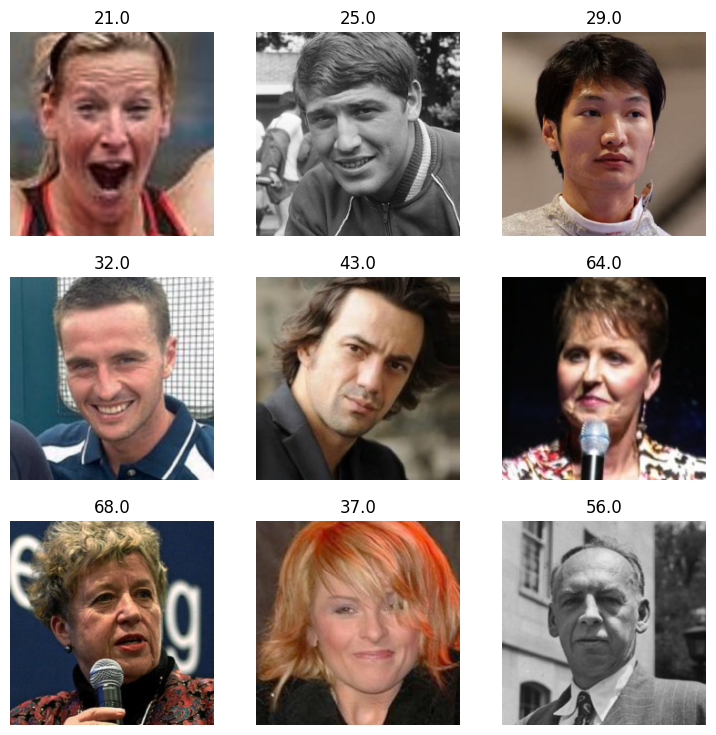

In [18]:
dls.show_batch()

In [24]:

dls.c


1

In [31]:

## resnet50

learn = cnn_learner(dls, resnet18, loss_func=MSELossFlat(), y_range=(0,100), metrics=[mae,rmse])


/Users/user/opt/anaconda3/envs/py37_GANs_Torch/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [34]:
## learn.lr_find()

In [35]:
learn.fine_tune(1, 1e-2)

epoch,train_loss,valid_loss,mae,_rmse,time
0,268.219849,205.801971,11.167157,14.345799,1:10:02


epoch,train_loss,valid_loss,mae,_rmse,time
0,86.759521,64.131920,6.079137,8.008241,1:42:17
